# Probit Model (EP)

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`
Precompiling project...
  ✓ RxInfer
  1 dependency successfully precompiled in 13 seconds. 238 already precompiled.


`RxInfer` comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a discrete observation model. Here, the probit function links continuous variable $x_t$ with the discrete variable $y_t$. The model is defined as:

$$\begin{aligned}
    u &= 0.1 \\
    x_0 &\sim \mathcal{N}(0, 100) \\
    x_t &\sim \mathcal{N}(x_{t-1}+ u, 0.01) \\
    y_t &\sim \mathrm{Ber}(\Phi(x_t))
\end{aligned}$$

## Import packages

In [2]:
using RxInfer, StableRNGs, Random, Plots
using StatsFuns: normcdf

##  Data generation

In [3]:
function generate_data(nr_samples::Int64; seed = 123)
    
    rng = StableRNG(seed)
    
    # hyper parameters
    u = 0.1

    # allocate space for data
    data_x = zeros(nr_samples + 1)
    data_y = zeros(nr_samples)
    
    # initialize data
    data_x[1] = -2
    
    # generate data
    for k = 2:nr_samples + 1
        
        # calculate new x
        data_x[k] = data_x[k-1] + u + sqrt(0.01)*randn(rng)
        
        # calculate y
        data_y[k-1] = normcdf(data_x[k]) > rand(rng)
        
    end
    
    # return data
    return data_x, data_y
    
end;

In [4]:
n = 40

40

In [5]:
data_x, data_y = generate_data(n);

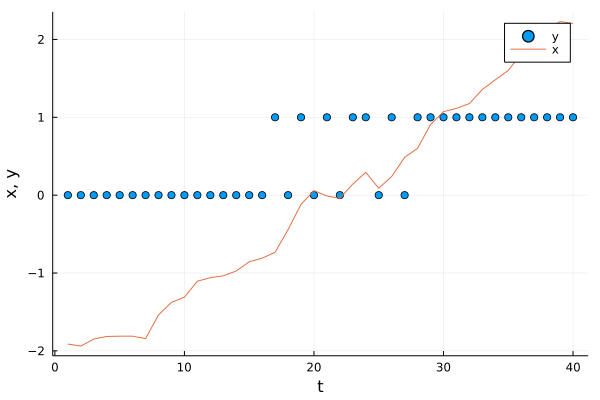

In [6]:
p = plot(xlabel = "t", ylabel = "x, y")
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x")

## Model specification

In [7]:
@model function probit_model(nr_samples::Int64)
    
    # allocate space for variables
    x = randomvar(nr_samples + 1)
    y = datavar(Float64, nr_samples)
    
    # specify uninformative prior
    x[1] ~ Normal(mean = 0.0, precision = 0.01)
    
    # create model 
    for k = 2:nr_samples + 1
        x[k] ~ Normal(mean = x[k - 1] + 0.1, precision = 100)
        y[k - 1] ~ Probit(x[k]) where {
            # Probit node by default uses RequireMessage pipeline with vague(NormalMeanPrecision) message as initial value for `in` edge
            # To change initial value use may specify it manually, like. Changes to the initial message may improve stability in some situations
            pipeline = RequireMessage(in = NormalMeanPrecision(0, 0.01)) 
        }
    end
    
end;

## Inference

In [8]:
result = inference(
    model = probit_model(length(data_y)), 
    data  = (y = data_y, ), 
    iterations = 5, 
    returnvars = (x = KeepLast(),),
    free_energy  = true
)

Inference results:
-----------------------------------------
Free Energy: Real[23.1779, 15.743, 15.6467, 15.6462, 15.6462]
-----------------------------------------
x = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=-11...


## Results

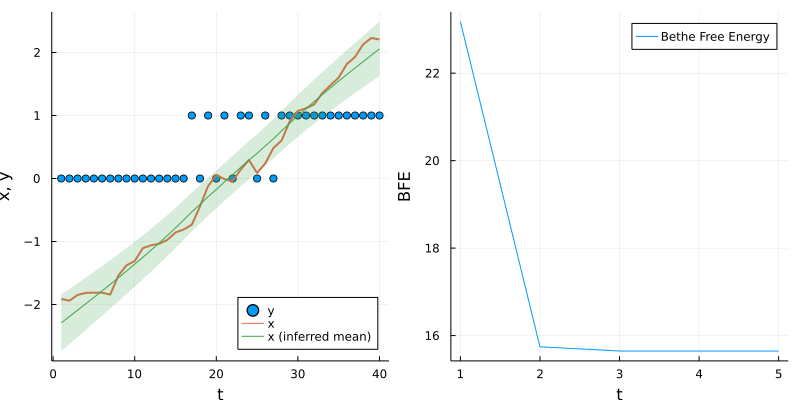

In [9]:
mx = result.posteriors[:x]

p = plot(xlabel = "t", ylabel = "x, y", legend = :bottomright)
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x", lw = 2)
p = plot!(mean.(mx)[2:end], ribbon = std.(mx)[2:end], fillalpha = 0.2, label="x (inferred mean)")

f = plot(xlabel = "t", ylabel = "BFE")
f = plot!(result.free_energy, label = "Bethe Free Energy")

plot(p, f, size = (800, 400))